In [2]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
from torch_geometric.datasets import QM9
import numpy as np
from torch.utils.data import random_split
# import jax
import matplotlib.pyplot as plt
import os

# Function to read and process data from the input format
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    features = []
    labels = []

    i = 0
    while i < len(lines):
        num_atoms = int(lines[i])
        energy = float(lines[i + 1].split()[-1])
        label = np.array([energy])

        atom_data = [line.split() for line in lines[i + 2:i + 2 + num_atoms]]
        coordinates = np.array([[float(coord) for coord in atom[1:]] for atom in atom_data])

        features.append(coordinates.flatten())
        labels.append(label)

        i += 2 + num_atoms

    return np.array(features), np.array(labels)


# Read data from the provided file
file_path = 'water-DZ-F12-STATIC-g32n10-3M_PES-DZERO.xyz'
features, labels = read_data(file_path)
print(features[3], labels[3])
print(len(features), len(labels))

[ 0.02860095  0.          0.43550962 -0.95333518  0.         -0.71874285
  0.49941735  0.         -0.36650326] [-76.24559204]
36003 36003


In [3]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

features = MinMaxScaler().fit_transform(features)

train_labelm = np.mean(labels)
train_labelstd = np.std(labels)

print("Mean = ", train_labelm, "Std =", train_labelstd)

transformed_labels = (labels - train_labelm) / train_labelstd
print(len(transformed_labels))
print(transformed_labels[1])
print(features[1])

test_size=0.2
train_features, test_features, train_labels, test_labels = train_test_split(
    features, transformed_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


Mean =  -76.1641637248784 Std = 0.2517673682079156
36003
[-0.43583645]
[0.625      0.         0.83375822 0.48264757 0.         0.2191029
 0.44083859 0.         0.28240713]


In [4]:
# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(9,)),  # Assuming 3 atoms with 3 coordinates each
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

In [5]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_features, train_labels, epochs=50, batch_size=16, validation_split=0.1)


Epoch 1/50


1621/1621 [==============================] - 4s 2ms/step - loss: 0.3105 - val_loss: 0.0536
Epoch 2/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0425 - val_loss: 0.0306
Epoch 3/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0191 - val_loss: 0.0101
Epoch 4/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0132 - val_loss: 0.0064
Epoch 5/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0089 - val_loss: 0.0039
Epoch 6/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 7/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 8/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 9/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 10/50
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0057 - val_los

In [6]:
# Evaluate the model on the test set
loss = model.evaluate(test_features, test_labels)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(test_features)

226/226 [==============================] - 0s 1ms/step - loss: 0.0112
Mean Squared Error on Test Set: 0.011240586638450623
226/226 [==============================] - 0s 1ms/step


MSE: 0.000712585803663379
RMSE: 0.026694302831566496
R-squared (R2) Score: 0.988423587120476


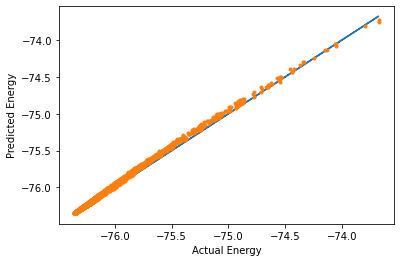

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Inverse transform the transformed labels
predictions = (predictions * train_labelstd) + train_labelm
test_labels = (test_labels * train_labelstd) + train_labelm


mse = mean_squared_error(test_labels, predictions)
print(f'MSE: {mse}')

rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print(f'RMSE: {rmse}')

r2 = r2_score(test_labels, predictions)
print("R-squared (R2) Score:", r2)


""" plt.scatter(test_labels, predictions) """
plt.plot(test_labels, test_labels, "-")
plt.plot(test_labels, predictions, ".")
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
#plt.title('Actual vs. Predicted Energy')
plt.show()